In [1]:
import qiskit.tools.jupyter
%qiskit_version_table

In [75]:
import qiskit
from qiskit import *
from qiskit.compiler import assemble
from qiskit.visualization import plot_histogram


import tensorflow as tf
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from tqdm import tqdm
from IPython import display

In [14]:
shots = 4000
number = 2
equality = shots / np.power(2, number)  # shots / 2**number. 

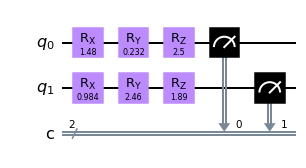

In [15]:
qc = QuantumCircuit(number, number)

rng = np.random.default_rng()

for i in range(number):
    qc.rx(rng.random() * np.pi, i)
    qc.ry(rng.random() * np.pi, i)
    qc.rz(rng.random() * np.pi, i)
    
qc.measure(range(number), range(number))
qc.draw("mpl")

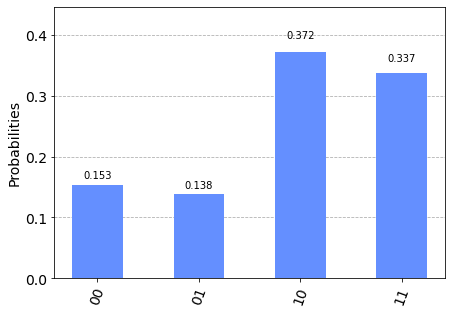

In [16]:
backend = Aer.get_backend('qasm_simulator')
circ = transpile(qc, backend)

qobj = assemble(circ, shots=shots)

# Run and get counts
result = backend.run(qobj).result()
counts = result.get_counts()
plot_histogram(counts)

# Machine Learning (ML)

What we are going to do is something similar to Generative Adversarial Network (GAN). For more information on GANs, please search online (e.g. https://wiki.pathmind.com/generative-adversarial-network-gan or any other webpages). 

In brief, GAN consists of 2 ML models called the generator and discriminator. If we take the concept of painting a picture. The generator will be a child trying to mimic painting a Mona Lisa. The discriminator will be the judge comparing the painted picture to the real Mona Lisa. And, depending on how good/bad the painting are, the discriminator will reward/punish the generator (with different strengths depending on the difference of course). The goal of the generator is to fool the discriminator into believing it is drawing a real Mona Lisa. The role of the discriminator is to ensure it always pick the correct real Mona Lisa. 

Ultimately, for the generator of a GAN, we would like to generate a matrix where it represents the rotational value of the matrix of Rx, Ry, and Rz gates, element-wise (or position-wise). 

However, we are going to replace the discriminator with a non-ML model. We are going to use the Qiskit Circuit as the discriminator. The resulting output will be the counts. 

Next, we will want to tune the parameters such that the output will be what we want. Say, like the above, we want all $00, 01, 10, 11$ to be equal (or it could be anything, we are just using "equal" to take it easy, one step at a time). 

Then after the generator generate a matrix of values, we will substitute them into the Circuit, then run the result for a number of shots to get the result. This result will be used in the calculation of Mean Squared Error (or Mean Absolute Error, Root Mean Squared Error, Earth Mover Distance, whatever useful...) and that error, which is called "loss", will be sent back to the generator. 

This process will be repeated until the generator can do so well. (Alternatively, until we humans are happy with the result, then we can stop training, since GAN are unstable). 

## Caveats

- It's not even sure whether this will work or not. Especially the discriminator is not a model and one had never done this before so this is an ambitious experimentation. 

In [20]:
target = {"00": equality, "01": equality, "10": equality, "11": equality}

print(target, "\n", counts)

{'00': 1000.0, '01': 1000.0, '10': 1000.0, '11': 1000.0} 
 {'00': 614, '01': 551, '10': 1488, '11': 1347}


### The Generator

In [136]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(2*3*1, use_bias=False, input_shape=(6, )))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Reshape((2, 3, 1)))
    model.add(layers.Conv2DTranspose(1, (2, 2), strides=(1, 1), padding="same", use_bias=False, activation="tanh"))
    assert model.output_shape == (None, 2, 3, 1)
    
    return model

In [137]:
generator = make_generator_model()

noise = tf.random.normal([1, 6])
generated_image = generator(noise, training=False)

np.squeeze(generated_image)

array([[-0.27240333, -0.13862278, -0.05024996],
       [ 0.33727655, -0.22472273, -0.2957398 ]], dtype=float32)

### The Discriminator

Note that the values generated are not the final value but we multiply by $\pi$ in the discriminator. This can or can not be done, depending on taste. However, whether it works better with or without requires further experimentation. 

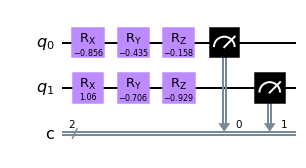

In [138]:
generated_image = np.squeeze(generated_image)

qc = QuantumCircuit(number, number)

for i in range(number):
    qc.rx(generated_image[i][0] * np.pi, i)
    qc.ry(generated_image[i][1] * np.pi, i)
    qc.rz(generated_image[i][2] * np.pi, i)
    
qc.measure(range(number), range(number))
qc.draw("mpl")

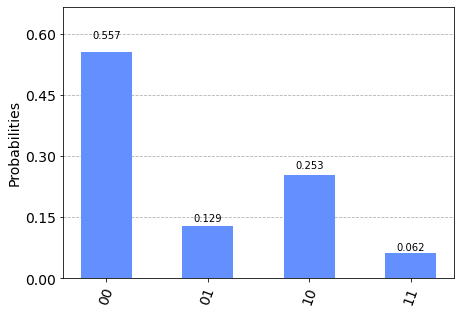

In [139]:
backend = Aer.get_backend('qasm_simulator')
circ = transpile(qc, backend)

qobj = assemble(circ, shots=shots)

# Run and get counts
result = backend.run(qobj).result()
counts = result.get_counts()
plot_histogram(counts)

In [140]:
mseloss = tf.keras.losses.MeanSquaredError()

#### One method of generator loss (gen_loss) is this

In [141]:
def gen_loss(y_true, y_pred):
    """
    Using Mean Squared Error (MSE) in this calculation. 
    
    :param y_true: (dict) The target we want to achieve. (i.e. Equality)
    :param y_pred: (dict) Output based on what is generated by generator. 
    """
    agg = 0
    for key in target.keys():
        y_true = target[key]
        y_pred = counts[key]
        
        mse_loss = np.square((y_true - y_pred) / shots)
        
        agg += mse_loss
        
    return agg

In [142]:
gen_loss(target, counts)

0.144304875

#### However another more useful one is this

In [143]:
df1 = pd.DataFrame(target, index=[0])
# df1 = df1.append(pd.DataFrame(counts, index=[0]))

# df1 = df1.T
df2 = pd.DataFrame(counts, index=[0])

In [144]:
target = {"00": equality, "01": equality, "10": equality, "11": equality}

def gen_loss(y_pred):
    """
    Using Mean Squared Error (MSE) in this calculation. 
    
    :param y_pred: (dict) Output based on what is generated by generator. 
    """
#     agg = 0
#     for key in target.keys():
#         y_true = target[key]
#         y_pred = counts[key]
        
#         mse_loss = np.square((y_true - y_pred) / shots)
        
#         agg += mse_loss

    # The y_true above is just 
    y_true = pd.DataFrame(target, index=[0]) / shots
    y_pred = pd.DataFrame(y_pred, index=[0]) / shots
    
    return mseloss(np.array(y_true), np.array(y_pred))

In [145]:
gen_loss(counts)

<tf.Tensor: shape=(), dtype=float64, numpy=0.03607621788978577>

I have no idea why they are different values. Perhaps I might have implement them wrongly. Whichever way, as long as we keep it consistent there shouldn't be big problem. If there is then we'll see how to solve it when it arise. 

In [146]:
cross_entropy = tf.losses.BinaryCrossentropy(from_logits=True, reduction=tf.losses.Reduction.SUM)

def gen_loss(y_pred):
    y_pred = pd.DataFrame(y_pred, index=[0]) / shots
    return cross_entropy(tf.ones_like(np.array(y_pred)), np.array(y_pred))

In [147]:
gen_opt = tf.keras.optimizers.Adam(1e-4)

In [148]:
BATCH_SIZE = 1
EPOCHS = 100
noise_dim = 6

seed = tf.random.normal([1, noise_dim])

In [149]:
backend = Aer.get_backend('qasm_simulator')


def discriminator(generated_image):
    generated_image = np.squeeze(generated_image)

    qc = QuantumCircuit(number, number)

    for i in range(number):
        qc.rx(generated_image[i][0] * np.pi, i)
        qc.ry(generated_image[i][1] * np.pi, i)
        qc.rz(generated_image[i][2] * np.pi, i)

    qc.measure(range(number), range(number))
    
    circ = transpile(qc, backend)

    qobj = assemble(circ, shots=shots)

    # Run and get counts
    result = backend.run(qobj).result()
    counts = result.get_counts()
    
    return counts

In [150]:
@tf.function
def train_step():
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    with tf.GradientTape() as gen_tape:
        generated_images = generator(noise, training=True)
        
#         real_output = target  # Put here to not confuse myself despite non-optimized. 
        fake_output = discriminator(generated_images)
        
        generator_loss = gen_loss(fake_output)
        
    gradients_of_generator = gen_tape.gradient(generator_loss, generator.trainable_variables)
    
    gen_opt.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

In [182]:
def train(epochs):
    for epoch in tqdm(range(epochs)):
        
#         train_step()
        noise = tf.random.normal([BATCH_SIZE, noise_dim])

        with tf.GradientTape() as gen_tape:
            generated_images = generator(noise, training=True)

    #         real_output = target  # Put here to not confuse myself despite non-optimized. 
            fake_output = discriminator(generated_images)

#             generator_loss = gen_loss(fake_output)

            generator_loss = cross_entropy(tf.zeros_like(generated_images), generated_images)
            

        gradients_of_generator = gen_tape.gradient(generator_loss, generator.trainable_variables)
        
        gen_opt.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        
    generate_output(generator, seed)

In [183]:
def generate_output(generator, seed):
    prediction = generator(seed, training=False)
    
    output = discriminator(prediction)
    
    plot_histogram(output)
    print(output)

In [184]:
train(EPOCHS)

100%|██████████| 100/100 [00:02<00:00, 41.92it/s]


{'00': 3996, '01': 4}


In [163]:
with tf.GradientTape() as gen_tape:
    generated_images = generator(noise, training=True)

#         real_output = target  # Put here to not confuse myself despite non-optimized. 
#     fake_output = discriminator(generated_images)
    
#     y_true = pd.DataFrame(target, index=[0]) / shots
#     y_pred = pd.DataFrame(fake_output, index=[0]) / shots
    
#     generator_loss =  mseloss(np.array(y_true), np.array(y_pred))

    generator_loss = cross_entropy(tf.ones_like(generated_images), generated_images)
    
# print(generator_loss)

gradients_of_generator = gen_tape.gradient(generator_loss, generator.trainable_variables)
# print(gradients_of_generator)
        

In [131]:
w = tf.Variable(tf.random.normal((3, 2)), name='w')
b = tf.Variable(tf.zeros(2, dtype=tf.float32), name='b')
x = [[1., 2., 3.]]

with tf.GradientTape(persistent=True) as tape:
  y = x @ w + b
  loss = tf.reduce_mean(y**2)
    
print(loss)

tf.Tensor(10.172235, shape=(), dtype=float32)


In [132]:
tape.gradient(loss, [w, b])

[<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
 array([[ 0.7124175,  4.453867 ],
        [ 1.424835 ,  8.907734 ],
        [ 2.1372523, 13.361601 ]], dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.7124175, 4.453867 ], dtype=float32)>]

In [133]:
[w, b]

[<tf.Variable 'w:0' shape=(3, 2) dtype=float32, numpy=
 array([[-0.14438994,  1.1685482 ],
        [ 0.13833162,  1.7407593 ],
        [ 0.1933814 , -0.06540004]], dtype=float32)>,
 <tf.Variable 'b:0' shape=(2,) dtype=float32, numpy=array([0., 0.], dtype=float32)>]

In [155]:
gen_tape.gradient(loss, generator.trainable_variables)

RuntimeError: GradientTape.gradient can only be called once on non-persistent tapes.